## Automated Deep Ensemble with Uncertainty Quantification

## Imports and GPU Detection <a class="anchor" id="imports-and-gpu-detection"></a>

<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.
    
</div>

## Installation from Develop Branch (fixed commit)

```console
git clone -b develop git@github.com:deephyper/deephyper.git
cd deephyper/
git checkout fc08b61efa0222945622ce661131bde4362e5ffe
pip install -e ".[default]"
```

In [1]:
#git clone -b develop git@github.com:deephyper/deephyper.git
#cd deephyper/
#git checkout fc08b61efa0222945622ce661131bde4362e5ffe
#pip install -e ".[default]"

In [2]:
#!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

In [3]:
import json
import os
import pathlib
import shutil

!export TF_CPP_MIN_LOG_LEVEL=3
!export TF_XLA_FLAGS=--tf_xla_enable_xla_devices

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

<div class="alert alert-info">
    
<b>Note</b>
    
The `TF_CPP_MIN_LOG_LEVEL` can be used to avoid the logging of Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

<div class="alert alert-info">
    
<b>Note</b>
    
The following can be used to detect if **GPU** devices are available on the current host.
    
</div>

In [4]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

No GPU available


In [5]:
dataset = np.load('../training-data/all_data.npy')

In [6]:
dataset.shape

(189, 1225)

In [7]:
dataset[:,0]

array([-2319.6447141 , -2319.40607004, -2319.63399504, -2319.63399504,
       -2319.56461213, -2319.58957939, -2319.66081293, -2319.61458265,
       -2319.61633854, -2319.47668683, -2319.58791233, -2319.59805758,
       -2319.57444436, -2319.03627754, -2319.54345216, -2319.45546986,
       -2319.15441285, -2319.10845954, -2318.73146826, -2319.10443649,
       -2319.07291553, -2318.34131056, -2318.54845714, -2319.10674703,
       -2319.02118615, -2319.21587163, -2319.11193483, -2319.03937137,
       -2319.0838334 , -2318.60375171, -2318.9919471 , -2319.1995488 ,
       -2318.72427134, -2319.18583175, -2319.08315693, -2318.98424475,
       -2318.62254706, -2319.27037827, -2318.72756577, -2319.26833524,
       -2318.88818962, -2319.15022144, -2319.11657124, -2318.60093464,
       -2319.26246818, -2318.61643112, -2319.10328198, -2319.14255954,
       -2319.13262361, -2318.9501868 , -2319.03255198, -2319.03994016,
       -2319.18815906, -2319.1302584 , -2319.14716248, -2319.17404103,
      

In [8]:
print(min(dataset[:,0]))
print(max(dataset[:,0]))

-2319.66081293
-2310.16642425


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [10]:
preprocessor_input = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_input.fit(dataset[:,1:])
preprocessor_output = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_output.fit(dataset[:,0].reshape(-1, 1))
X = preprocessor_input.transform(dataset[:,1:])
Y = preprocessor_output.transform(dataset[:,0].reshape(-1, 1))
print(X.shape)
print(Y.shape)
print(Y)
Y_train = Y

(189, 1224)
(189, 1)
[[0.00169562]
 [0.02683089]
 [0.0028246 ]
 [0.0028246 ]
 [0.01013238]
 [0.0075027 ]
 [0.        ]
 [0.00486922]
 [0.00468428]
 [0.01939315]
 [0.00767828]
 [0.00660973]
 [0.0090968 ]
 [0.06577942]
 [0.01236107]
 [0.02162783]
 [0.05333678]
 [0.05817683]
 [0.09788357]
 [0.05860055]
 [0.06192051]
 [0.13897708]
 [0.11715929]
 [0.0583572 ]
 [0.06736893]
 [0.04686361]
 [0.05781079]
 [0.06545356]
 [0.06077058]
 [0.11133536]
 [0.07044854]
 [0.04858282]
 [0.09864159]
 [0.05002757]
 [0.06084183]
 [0.07125979]
 [0.10935574]
 [0.04112267]
 [0.0982946 ]
 [0.04133786]
 [0.08137684]
 [0.05377824]
 [0.05732246]
 [0.11163207]
 [0.04195581]
 [0.1099999 ]
 [0.05872215]
 [0.05458523]
 [0.05563174]
 [0.07484696]
 [0.06617182]
 [0.06539365]
 [0.04978244]
 [0.05588085]
 [0.05410042]
 [0.05126943]
 [0.06624795]
 [0.03634319]
 [0.09530883]
 [0.04399968]
 [0.05002537]
 [0.05693853]
 [0.05941338]
 [0.05387696]
 [0.06404568]
 [0.07517292]
 [0.06798982]
 [0.12798836]
 [0.05715717]
 [0.12049781]

In [11]:
dataset_test1 = np.load('../poscar_data/npy_data/feature_vectors_01.npy')
dataset_test2 = np.load('../poscar_data/npy_data/feature_vectors_02.npy')
dataset_test3 = np.load('../poscar_data/npy_data/feature_vectors_03.npy')
dataset_test4 = np.load('../poscar_data/npy_data/feature_vectors_04.npy')
dataset_test5 = np.load('../poscar_data/npy_data/feature_vectors_05.npy')

In [12]:
dataset_test = np.concatenate((dataset_test1,dataset_test2,dataset_test3,dataset_test4,dataset_test5), axis=0)

In [13]:
X_test = preprocessor_input.transform(dataset_test)

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_PCA = pca.fit(X)
print(pca.explained_variance_ratio_)

[8.84273750e-01 5.03982778e-02 3.36601537e-02 1.05068437e-02
 7.78598044e-03 4.64567136e-03 2.74585984e-03 1.32655891e-03
 1.04568513e-03 9.30753846e-04 6.61044046e-04 5.36579400e-04
 3.48020759e-04 2.12472745e-04 1.61378258e-04 1.29472889e-04
 1.00020986e-04 8.43440568e-05 6.22524915e-05 5.32187743e-05
 4.69372641e-05 3.67146033e-05 3.44151052e-05 2.80821735e-05
 2.48786982e-05 2.19230142e-05 2.05195034e-05 1.65556806e-05
 1.51838408e-05 1.12382480e-05 8.19446322e-06 7.31452655e-06
 6.63341620e-06 5.44359515e-06 4.62657897e-06 4.48309464e-06
 4.10062999e-06 3.68380083e-06 3.29107398e-06 2.93257679e-06
 2.68427070e-06 2.13736921e-06 2.11029724e-06 1.81509553e-06
 1.75924431e-06 1.53805393e-06 1.09879270e-06 1.07501441e-06
 1.00159635e-06 8.52128263e-07 7.69171656e-07 6.72572322e-07
 6.48467397e-07 5.55689717e-07 5.11801963e-07 4.71136798e-07
 4.18613962e-07 3.69976942e-07 3.61050477e-07 3.09213632e-07
 2.82106965e-07 2.54534571e-07 2.39766754e-07 2.13374032e-07
 2.00624070e-07 1.820022

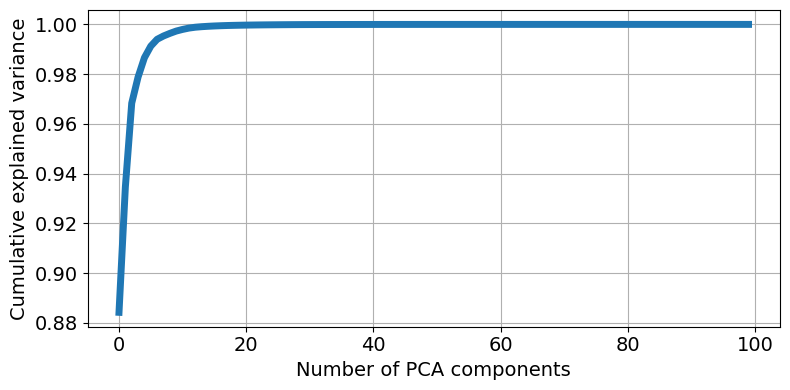

In [15]:
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_),linewidth=5)
plt.xlabel('Number of PCA components', fontsize=14)
plt.ylabel('Cumulative explained variance',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig('train-pca.png')

In [16]:
X_train_PCA = pca.transform(X)
X_test_PCA = pca.transform(X_test)

In [17]:
flags = [0] * X_test_PCA.shape[0] + [1] * X_train_PCA.shape[0]

In [18]:
print(X_train_PCA.shape)
print(X_test_PCA.shape)

(189, 100)
(50000, 100)


In [19]:
all_X_data = np.concatenate((X_test_PCA,X_train_PCA), axis=0)

In [20]:
#from sklearn.manifold import TSNE
#X_embedded = TSNE(n_components=2).fit_transform(all_X_data)
#X_embedded.shape

In [21]:
if 0:
    import matplotlib.pyplot as plt
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=flags, cmap='rainbow')
    plt.colorbar()
    plt.show()

## Start Ray

We launch the Ray run-time depending on the detected local ressources. If GPU(s) is(are) detected then 1 worker is started for each GPU. If not, then only 1 worker is started. You can start more workers by setting `num_cpus=1` to a value greater than 1.

<div class="alert alert-warning">

<b>Warning</b>
    
In the case of GPUs it is important to follow this scheme to avoid multiple processes (Ray workers vs current process) to lock the same GPU.
    
</div>

In [22]:
import ray

if not(ray.is_initialized()):
    if is_gpu_available:
        ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)            
    else:
        ray.init(num_cpus=4, log_to_driver=False)

/Users/p12/anaconda3/envs/dh/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-24 21:13:54,853	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-10-24 21:13:56,598	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [23]:
def load_data_train_test(random_state=42):
    X = X_train_PCA #np.load('X.npy')
    Y = Y_train #np.load('Y.npy')

    return (X, Y), (X, Y)

In [24]:
from sklearn.model_selection import train_test_split

def load_data_train_valid(verbose=0, random_state=42):

    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state
    )

    if verbose:
        print(f'train_X shape: {np.shape(train_X)}')
        print(f'train_y shape: {np.shape(train_y)}')
        print(f'valid_X shape: {np.shape(valid_X)}')
        print(f'valid_y shape: {np.shape(valid_y)}')
    return (train_X, train_y), (valid_X, valid_y)


(x, y), (vx, vy) = load_data_train_valid(verbose=1)
_, (tx , ty) = load_data_train_test()

train_X shape: (126, 100)
train_y shape: (126, 1)
valid_X shape: (63, 100)
valid_y shape: (63, 1)


In [25]:
s_x = x
s_y = y
s_vx = vx
s_vy = vy

In [26]:
s_x.shape

(126, 100)

## Define the Neural Architecture Search Space <a class="anchor" id="define-the-neural-architecture-search-space"></a>

The neural architecture search space is composed of discrete decision variables. For each decision variable we choose among a list of possible operation to perform (e.g., fully connected, ReLU). To define this search space, it is necessary to use two classes:

* `KSearchSpace` (for Keras Search Space): represents a directed acyclic graph (DAG) in which each node represents a chosen operation. It represents the possible neural networks that can be created.
* `SpaceFactory`: is a utilitiy class used to pack the logic of a search space definition and share it with others.

Then, inside a `KSearchSpace` we will have two types of nodes:
* `VariableNode`: corresponds to discrete decision variables and are used to define a list of possible operation.
* `ConstantNode`: corresponds to fixed operation in the search space (e.g., input/outputs)

Finally, it is possible to reuse any `tf.keras.layers` to define a `KSearchSpace`. However, it is important to wrap each layer in an `operation` to perform a lazy memory allocation of tensors.

In [27]:
if 1:
    import collections

    from deephyper.nas import KSearchSpace

    # Decision variables are represented by nodes in a graph
    from deephyper.nas.node import ConstantNode, VariableNode

    # The "operation" creates a wrapper around Keras layers avoid allocating 
    # memory each time a new layer is defined in the search space
    # For Skip/Residual connections we use "Zero", "Connect" and "AddByProjecting"
    from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity

    Dense = operation(tf.keras.layers.Dense)

    # Possible activation functions
    ACTIVATIONS = [
        tf.keras.activations.elu,
        tf.keras.activations.gelu,
        tf.keras.activations.hard_sigmoid,
        tf.keras.activations.linear,
        tf.keras.activations.relu,
        tf.keras.activations.selu,
        tf.keras.activations.sigmoid,
        tf.keras.activations.softplus,
        tf.keras.activations.softsign,
        tf.keras.activations.swish,
        tf.keras.activations.tanh,
    ]

We implement the constructor `__init__` and `build` method of the `RegressionSpace` a subclass of `KSearchSpace`. The `__init__` method interface is:

```python
def __init__(self, input_shape, output_shape, **kwargs):
    ...
```

for the `build` method the interface is:

```python
def build(self):
    ...
    return self
```

where:
* `input_shape` corresponds to a tuple or a list of tuple indicating the shapes of inputs tensors.
* `output_shape` corresponds to the same but of output_tensors.
* `**kwargs` denotes that any other key word argument can be defined by the user.

In [28]:
if 1:
    class RegressionSpace(KSearchSpace):

        def __init__(self, input_shape, output_shape, seed=None, num_layers=3):
            super().__init__(input_shape, output_shape, seed=seed)

            self.num_layers = 3

        def build(self):

            # After creating a KSearchSpace nodes corresponds to the inputs are directly accessible
            out_sub_graph = self.build_sub_graph(self.input_nodes[0], self.num_layers)

            output = ConstantNode(op=Dense(self.output_shape[0]))  
            self.connect(out_sub_graph, output)

            return self

        def build_sub_graph(self, input_node, num_layers=3):


            # Look over skip connections within a range of the 3 previous nodes
            anchor_points = collections.deque([input_node], maxlen=3)

            prev_node = input_node

            for _ in range(num_layers):

                # Create a variable node to list possible "Dense" layers
                dense = VariableNode()

                # Add the possible operations to the dense node
                self.add_dense_to_(dense)

                # Connect the previous node to the dense node
                self.connect(prev_node, dense)

                # Create a constant node to merge all input connections
                merge = ConstantNode()
                merge.set_op(
                    AddByProjecting(self, [dense], activation="relu")
                )

                for node in anchor_points:

                    # Create a variable node for each possible connection
                    skipco = VariableNode()

                    skipco.add_op(Zero()) # corresponds to no connection
                    skipco.add_op(Connect(self, node)) # corresponds to (node => skipco)

                    # Connect the (skipco => merge)
                    self.connect(skipco, merge)


                # ! for next iter
                prev_node = merge
                anchor_points.append(prev_node)

            return prev_node

        def add_dense_to_(self, node):

            # We add the "Identity" operation to allow the choice "doing nothing"
            node.add_op(Identity())

            step = 16
            for units in range(step, step * 16 + 1, step):
                for activation in ACTIVATIONS:
                    node.add_op(Dense(units=units, activation=activation))


Let us visualize a few randomly sampled neural architecture from this search space.

## Define the Neural Architecture Optimization Problem <a class="anchor" id="define-the-neural-architecture-search-optimization-problem"></a>

In order to define a neural architecture search problem we have to use the `NaProblem` class. This class gives access to different method for the user to customize the training settings of neural networks.

In [29]:
if 1:
    from deephyper.problem import NaProblem


    def stdscaler():
        return StandardScaler()


    problem = NaProblem()

    # Bind a function which returns (train_input, train_output), (valid_input, valid_output)
    problem.load_data(load_data_train_valid)

    # Bind a function which return a scikit-learn preprocessor (with fit, fit_transform, inv_transform...etc)
    #problem.preprocessing(stdscaler)

    # Bind a function which returns a search space and give some arguments for the `build` method
    problem.search_space(RegressionSpace, num_layers=3)

    # Define a set of fixed hyperparameters for all trained neural networks
    problem.hyperparameters(
        batch_size=4,
        learning_rate=1e-3,
        optimizer="adam",
        num_epochs=200,
        callbacks=dict(
            EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=30)
        ),
    )

    # Define the loss to minimize
    problem.loss("mse")

    # Define complementary metrics
    problem.metrics([])

    # Define the maximized objective. Here we take the negative of the validation loss.
    problem.objective("-val_loss")

    problem

<div class="alert alert-info">
    
<b>Tip</b>
    
Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=30)
...
```
    
</div>



## Define the Evaluator Object

The `Evaluator` object is responsible of defining the backend used to distribute the function evaluation in DeepHyper.

In [30]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback


def get_evaluator(run_function):
    
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [LoggerCallback()] # To interactively follow the finished evaluations,
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

For neural architecture search a standard training pipeline is provided by the `run_base_trainer` function from the `deephyper.nas.run` module.

In [31]:
from deephyper.nas.run import run_base_trainer

## Define and Run the Neural Architecture Search

All search algorithms follow a similar interface. A `problem` and `evaluator` object has to be provided to the search then the search can be executed through the `search(max_evals, timeout)` method.

By default, the `RegularizedEvolution` has a population size of 100 therefore, it will start optimizing only after 100 evaluations.

We can now compare the search trajectories for different algorithms.

If we look at the dataframe of results for each search we will find it slightly different than the one of hyperparameter search. A new column `arch_seq` corresponds to an embedding for each evaluated architecture. Each integer of an `arch_seq` list corresponds to the choice of a `VariableNode` in our `KSearchSpace`.

Let us visualize the best architecture found:

## Adding Uncertainty Quantification to the Baseline Neural Network

To add uncertainty estimates we use the [Tensorflow Probability](https://www.tensorflow.org/probability) library which is fully compatible with the neural architecture search API because it is accessible through Keras layers.

In [32]:
if 1:
    import tensorflow_probability as tfp
    tfd = tfp.distributions

Then, instead of minimising the mean squared error we will minimize the negative log-likelihood baed on the learned probability distribution $p(y|\mathbf{x};\theta)$ where $\theta$ represents a neural network (architecture, training hyperparameters, weights).

In [33]:
if 1:
    def nll(y, rv_y):
        """Negative log likelihood for Tensorflow probability.

        Args:
            y: true data.
            rv_y: learned (predicted) probability distribution.
        """
        return -rv_y.log_prob(y)

Let us visualize the learned uncertainty estimates.

The learned mean estimates appears to be worse than when minimizing the mean squared error loss. Also, we can see than the variance estimate are not meaningful in areas missing data (white background) and do not learn properly the noise in are with data (grey background).

## Ensemble of Neural Networks With Random Initialization



The `UQBaggingEnsembleRegressor` provides different strategies to build ensemble of neural networks from a library of saved models. The computation is distributed with Ray (for the inference and ranking of ensemble members).

In [34]:
if 1:
    from deephyper.ensemble import UQBaggingEnsembleRegressor

    ensemble = UQBaggingEnsembleRegressor(
        model_dir="models_random_init",
        loss=nll,  # default is nll
        size=5,
        verbose=True,
        ray_address="auto",
        num_cpus=1,
        num_gpus=1 if is_gpu_available else None,
        selection="topk",
    )

We can visualize the uncertainty estimate of such ensemble.

By using the **Law of Total Variance** we can decompose the aleatoric and epistemic components of the predicted uncertainty. With random-initialization we can see that epistemic uncertainty is almost null everywhere and not informative on area missing data (white background).

## AutoDEUQ: Automated Deep Ensemble with Uncertainty Quantification

AutoDEUQ is an algorithm in 2 steps:
1. joint hyperparameter and neural architecture search to generate a catalog of models.
2. build an ensemble from the catalog

To this end we start by editing slightly the previous `RegressionFactory` by adding the `DistributionLambda` layer as output.

In [35]:
DistributionLambda = operation(tfp.layers.DistributionLambda)

In [36]:
class RegressionUQSpace(KSearchSpace):
    
    def __init__(self, input_shape, output_shape, seed=None, num_layers=3):
        super().__init__(input_shape, output_shape, seed=seed)
        
        self.num_layers = 3
    
    def build(self):

        out_sub_graph = self.build_sub_graph(self.input_nodes[0], self.num_layers)
        
        output_dim = self.output_shape[0]
        output_dense = ConstantNode(op=Dense(output_dim*2))  
        self.connect(out_sub_graph, output_dense)
        
        
        output_dist = ConstantNode(
            op=DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :output_dim],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., output_dim:]),
                )
            )
        )
        self.connect(output_dense, output_dist)

        return self

    def build_sub_graph(self, input_node, num_layers=3):
        

        # Look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([input_node], maxlen=3)
        
        prev_node = input_node
        
        for _ in range(num_layers):
            
            # Create a variable node to list possible "Dense" layers
            dense = VariableNode()
            
            # Add the possible operations to the dense node
            self.add_dense_to_(dense)
            
            # Connect the previous node to the dense node
            self.connect(prev_node, dense)

            # Create a constant node to merge all input connections
            merge = ConstantNode()
            merge.set_op(
                AddByProjecting(self, [dense], activation="relu")
            )

            for node in anchor_points:
                
                # Create a variable node for each possible connection
                skipco = VariableNode()
                
                skipco.add_op(Zero()) # corresponds to no connection
                skipco.add_op(Connect(self, node)) # corresponds to (node => skipco)
                
                # Connect the (skipco => merge)
                self.connect(skipco, merge)

 
            # ! for next iter
            prev_node = merge
            anchor_points.append(prev_node)

        return prev_node

    def add_dense_to_(self, node):
        
        # We add the "Identity" operation to allow the choice "doing nothing"
        node.add_op(Identity())
        
        step = 16
        for units in range(step, step * 16 + 1, step):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))

For joint hyperparameter and neural architecture search it is possible to use the `problem.add_hyperparameter(...)` to define variable hyperparameters in the NAS Problem.

In [37]:
problem_uq = NaProblem()

problem_uq.load_data(load_data_train_valid)

#problem_uq.preprocessing(stdscaler)

problem_uq.search_space(RegressionUQSpace, num_layers=3)

problem_uq.hyperparameters(
    batch_size=problem_uq.add_hyperparameter((1, 32), "batch_size"),
    learning_rate=problem_uq.add_hyperparameter(
        (1e-4, 0.1, "log-uniform"),
        "learning_rate",
    ),
    optimizer=problem_uq.add_hyperparameter(
        ["sgd", "rmsprop", "adagrad", "adam", "adadelta", "adamax", "nadam"],
        "optimizer",
    ),
    patience_ReduceLROnPlateau=problem_uq.add_hyperparameter(
        (10, 20), "patience_ReduceLROnPlateau"
    ),
    patience_EarlyStopping=problem_uq.add_hyperparameter(
        (20, 30), "patience_EarlyStopping"
    ),
    num_epochs=200,
    callbacks=dict(
        ReduceLROnPlateau=dict(monitor="val_loss", mode="min", verbose=0, patience=5),
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=10),
        # We save trained models in neural architecture search
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        ),
    ),
)

problem_uq.loss(nll)

problem_uq.metrics([])

# The objective is maximized so we take the negative of the validation loss
# where the loss is minimized
problem_uq.objective("-val_loss")

problem_uq

Problem is:
    - search space   : __main__.RegressionUQSpace
    - data loading   : __main__.load_data_train_valid
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: batch_size, Type: UniformInteger, Range: [1, 32], Default: 16
        * learning_rate: learning_rate, Type: UniformFloat, Range: [0.0001, 0.1], Default: 0.0031622777, on log-scale
        * optimizer: optimizer, Type: Categorical, Choices: {sgd, rmsprop, adagrad, adam, adadelta, adamax, nadam}, Default: sgd
        * patience_ReduceLROnPlateau: patience_ReduceLROnPlateau, Type: UniformInteger, Range: [10, 20], Default: 15
        * patience_EarlyStopping: patience_EarlyStopping, Type: UniformInteger, Range: [20, 30], Default: 25
        * num_epochs: 200
        * callbacks: {'ReduceLROnPlateau': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 5}, 'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 10}, 'ModelCheckpoint': {'monitor'

In [38]:
results_uq = {}

The `max_evals` has to be superior or equal to 400 to start having a good UQ estimate.

In [39]:
from deephyper.search.nas import AgEBO


load_from_checkpoint = True
if not(load_from_checkpoint):
    
    if os.path.exists("agebo_search"):
        shutil.rmtree("agebo_search")
        
    # "n_jobs" is the number of processes used to refresh the state of the surrogate model used in AgEBO 
    agebo_search = AgEBO(problem_uq, get_evaluator(run_base_trainer), log_dir="agebo_search", n_jobs=4)

    results_uq["agebo"] = agebo_search.search(max_evals=150)

In [40]:
if not(load_from_checkpoint):
    results_uq["agebo"]

Different sizes of ensemble and two selection strategies can be experimented for ensembles:
* `caruana`: a greedy selection from Caruana based on the loss function.
* `topk`: select the top-k (i.e., `size`) best models based on the loss function.

In [41]:
ensemble = UQBaggingEnsembleRegressor(
    model_dir="agebo_search/save/model",
    loss=nll,  # default is nll
    size=10,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="caruana",
)

if load_from_checkpoint:
    ensemble.load("agebo_search/ensemble.json")
else:
    ensemble.fit(s_vx, s_vy)
    ensemble.save("agebo_search/ensemble.json")

print(f"Selected {len(ensemble.members_files)} members are: ", ensemble.members_files)

Selected 23 members are:  ['0.58.h5', '0.118.h5', '0.72.h5', '0.72.h5', '0.121.h5', '0.72.h5', '0.72.h5', '0.72.h5', '0.33.h5', '0.72.h5', '0.72.h5', '0.72.h5', '0.72.h5', '0.72.h5', '0.72.h5', '0.72.h5', '0.117.h5', '0.72.h5', '0.72.h5', '0.72.h5', '0.72.h5', '0.72.h5', '0.72.h5']


In [42]:
import json

members_infos = {}
print("Number of parameters of ensemble members: ")
for member_file in set(ensemble.members_files):
    member_id = member_file[:-3]
    with open(f"agebo_search/save/history/{member_id}.json", "r") as fp:
        members_infos[member_id] = json.load(fp)
        print(f" - id:{member_id} -> {members_infos[member_id]['n_parameters']} parameters")
       

Number of parameters of ensemble members: 
 - id:0.121 -> 59906 parameters
 - id:0.72 -> 52962 parameters
 - id:0.117 -> 84098 parameters
 - id:0.118 -> 114114 parameters
 - id:0.33 -> 21746 parameters
 - id:0.58 -> 64978 parameters


 - id:0.121 -> 9 layers
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 16)                   1616      ['input_0[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 240)                  4080      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 112)                  26992     ['dense_1[0][0]']             
                                                                      

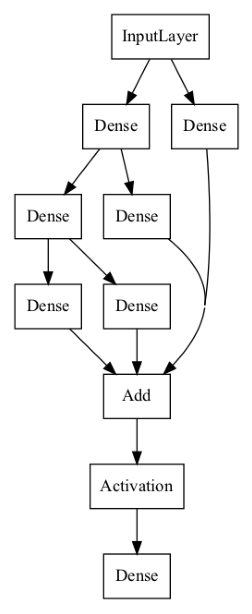

 - id:0.72 -> 11 layers
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 144)                  14544     ['input_0[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 16)                   2320      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                  2176      ['dense_1[0][0]']             
                                                                      

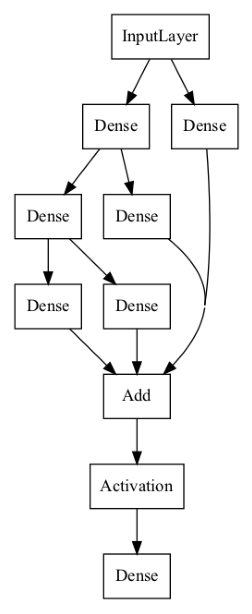

 - id:0.117 -> 15 layers
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 240)                  24240     ['input_0[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 240)                  24240     ['input_0[0][0]']             
                                                                                                  
 add (Add)                   (None, 240)                  0         ['dense[0][0]',               
                                                                     

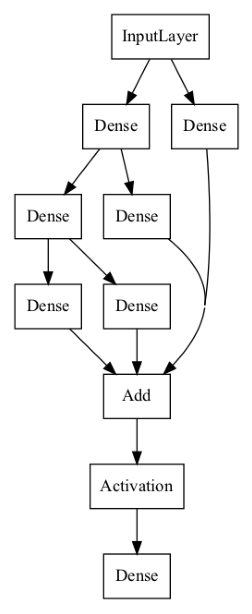

 - id:0.118 -> 9 layers
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 16)                   1616      ['input_0[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 240)                  4080      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 224)                  53984     ['dense_1[0][0]']             
                                                                      

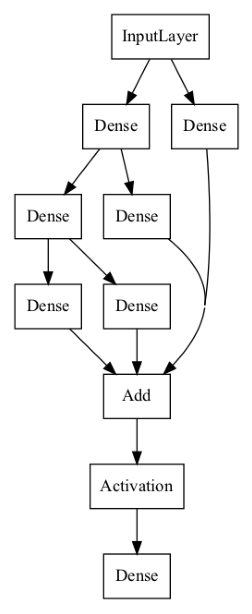

 - id:0.33 -> 13 layers
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 16)                   1616      ['input_0[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 32)                   544       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 32)                   544       ['dense[0][0]']               
                                                                      

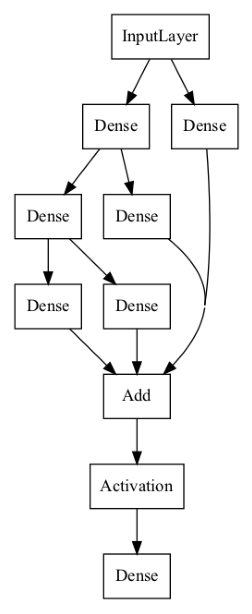

 - id:0.58 -> 13 layers
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  25856     ['input_0[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 48)                   12336     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 48)                   4848      ['input_0[0][0]']             
                                                                      

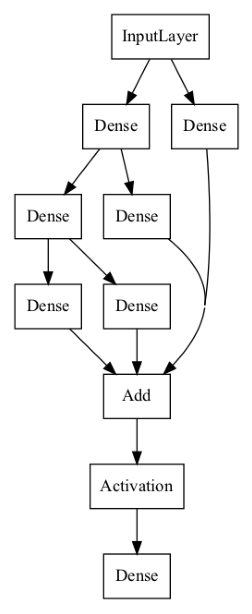

In [43]:
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.utils import plot_model

for member_file in set(ensemble.members_files):
    member_id = member_file[:-3]
    
    model_path = f"agebo_search/save/model/{member_id}.h5"
    model = tf.keras.models.load_model(model_path, compile=False)
    
    print(f" - id:{member_id} -> {len(model.layers)} layers")
    
    if 1:
        model.summary()
        plt.figure(figsize=(3,8))
        plot_model(model, "model.png", show_shapes=True, show_layer_names=True)
        image = mpimg.imread("random_model.png")
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [44]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_x)

pred_ty_mean = pred_s_ty.loc.numpy() 
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var 
pred_ty_epistemic_var = pred_s_ty_epistemic_var 

In [45]:
from sklearn.metrics import mean_squared_error, r2_score


y_true = preprocessor_output.inverse_transform(s_y).flatten()
y_pred = preprocessor_output.inverse_transform(pred_ty_mean).flatten()

rmse_train = mean_squared_error(y_true, y_pred, squared=False)
r2_train = r2_score(y_true, y_pred)

print(f"RMSE Training: {rmse_train:.3f}")
print(f"R2   Training: {r2_train:.3f}")

RMSE Training: 0.074
R2   Training: 1.000


In [46]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_vx)

pred_ty_mean = pred_s_ty.loc.numpy() 
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var 
pred_ty_epistemic_var = pred_s_ty_epistemic_var 

In [67]:
from sklearn.metrics import mean_squared_error, r2_score


y_true = preprocessor_output.inverse_transform(s_vy).flatten()
y_pred = preprocessor_output.inverse_transform(pred_ty_mean).flatten()

rmse_valid = mean_squared_error(y_true, y_pred, squared=False)
r2_valid = r2_score(y_true, y_pred)

print(f"RMSE Valid: {rmse_valid:.3f}")
print(f"R2   Valid: {r2_valid:.3f}")

RMSE Valid: 0.208
R2   Valid: 0.997


In [48]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_x)

pred_ty_mean = pred_s_ty.loc.numpy() 
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var 
pred_ty_epistemic_var = pred_s_ty_epistemic_var 

In [49]:
# 95.44% interval
pred_ty_aleatoric_interval = np.sqrt(pred_ty_aleatoric_var) 
pred_ty_epistemic_interval = np.sqrt(pred_ty_epistemic_var)
aleatoric_ub = preprocessor_output.inverse_transform(pred_ty_mean + pred_ty_aleatoric_interval)
mid = preprocessor_output.inverse_transform(pred_ty_mean)
aleatoric_error = aleatoric_ub - mid
epistemic_ub = preprocessor_output.inverse_transform(pred_ty_mean + pred_ty_epistemic_interval)
epistemic_error = epistemic_ub - mid

In [50]:
print(aleatoric_error.shape)
print(epistemic_error.shape)
print(preprocessor_output.inverse_transform(s_y).flatten().shape)
print(preprocessor_output.inverse_transform(pred_ty_mean).flatten().shape)
min_train = np.min(preprocessor_output.inverse_transform(s_y).flatten())
max_train = np.max(preprocessor_output.inverse_transform(s_y).flatten())
print(min_train)

(126, 1)
(126, 1)
(126,)
(126,)
-2319.66081293


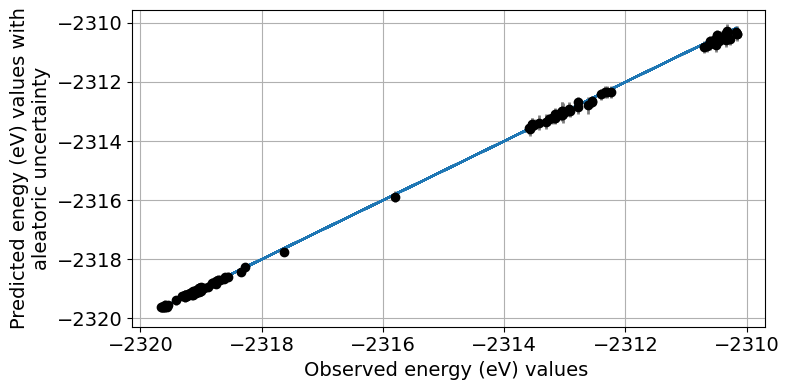

In [51]:
plt.figure(figsize=(8,4))
plt.errorbar(preprocessor_output.inverse_transform(s_y).flatten(),
             preprocessor_output.inverse_transform(pred_ty_mean).flatten(),
             aleatoric_error.flatten(),
             fmt='o', color='black',
             ecolor='gray', elinewidth=2, capsize=0)
plt.plot(preprocessor_output.inverse_transform(s_y).flatten(),preprocessor_output.inverse_transform(s_y).flatten())
plt.xlabel("Observed energy (eV) values ", fontsize=14)
plt.ylabel(r"Predicted enegy (eV) values with" 
           "\n" r"aleatoric uncertainty",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
#plt.axline([0, 0], [1, 1])
plt.savefig('train-ale-uq.png')

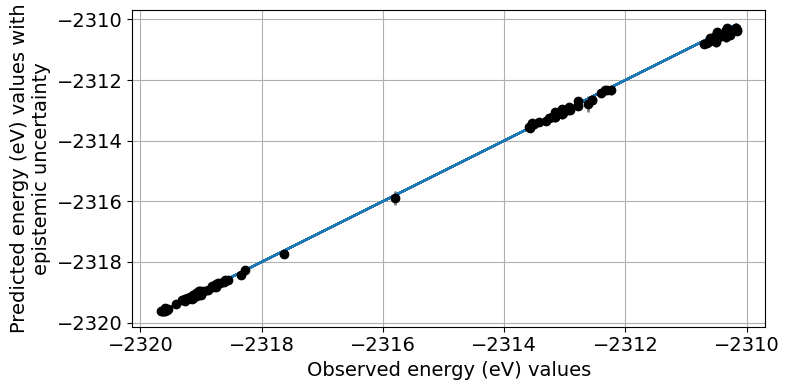

In [52]:
plt.figure(figsize=(8,4))
plt.errorbar(preprocessor_output.inverse_transform(s_y).flatten(),
             preprocessor_output.inverse_transform(pred_ty_mean).flatten(),
             epistemic_error.flatten(),
             fmt='o', color='black',
             ecolor='gray', elinewidth=2, capsize=0)
             #linestyle='None', marker='^')
plt.plot(preprocessor_output.inverse_transform(s_y).flatten(),preprocessor_output.inverse_transform(s_y).flatten())
plt.xlabel("Observed energy (eV) values", fontsize=14)
plt.ylabel(r"Predicted energy (eV) values with" 
           "\n" r"epistemic uncertainty",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
#plt.axline([0, 0], [1, 1])
plt.savefig('train-epi-uq.png')

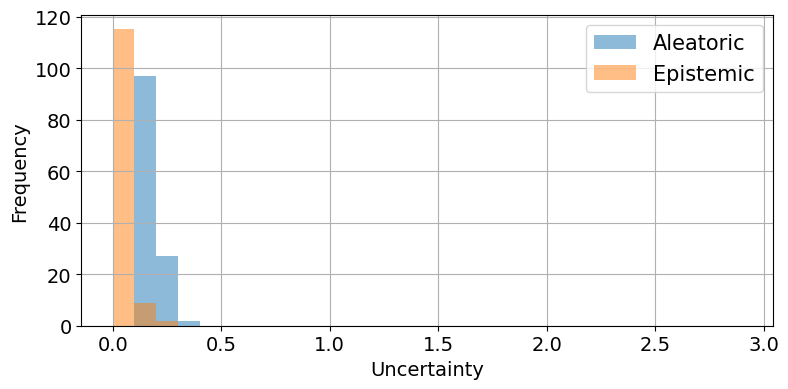

In [53]:
from matplotlib import pyplot

bins = np.arange(0.0,3.0,0.1)

plt.figure(figsize=(8,4))
pyplot.hist(aleatoric_error, bins, alpha=0.5, label='Aleatoric')
pyplot.hist(epistemic_error, bins, alpha=0.5, label='Epistemic')
pyplot.legend(loc='upper right',prop={'size': 15})
pyplot.xlabel("Uncertainty", fontsize=14)
pyplot.ylabel("Frequency",fontsize=14)
pyplot.xticks(fontsize=14)
pyplot.yticks(fontsize=14)
pyplot.grid()
pyplot.tight_layout()
pyplot.savefig('train-hist-uq.png')

In [54]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(X_test_PCA)

pred_ty_mean = pred_s_ty.loc.numpy() 
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var 
pred_ty_epistemic_var = pred_s_ty_epistemic_var 

In [55]:
# 95.44% interval
pred_ty_aleatoric_interval = np.sqrt(pred_ty_aleatoric_var) 
pred_ty_epistemic_interval = np.sqrt(pred_ty_epistemic_var) 
aleatoric_ub = preprocessor_output.inverse_transform(pred_ty_mean+pred_ty_aleatoric_interval)
epistemic_ub = preprocessor_output.inverse_transform(pred_ty_mean+pred_ty_epistemic_interval)
mid = preprocessor_output.inverse_transform(pred_ty_mean)
aleatoric_error = aleatoric_ub - mid
epistemic_error = epistemic_ub - mid

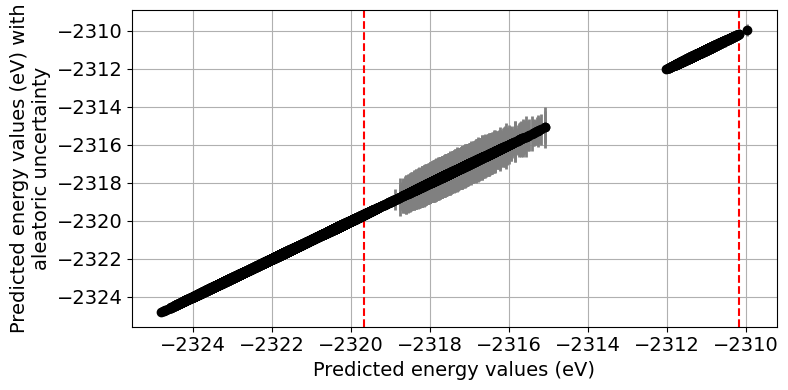

In [56]:
plt.figure(figsize=(8,4))
plt.errorbar(preprocessor_output.inverse_transform(pred_ty_mean).flatten(),
             preprocessor_output.inverse_transform(pred_ty_mean).flatten(),
             aleatoric_error.flatten(),
             fmt='o', color='black',
             ecolor='gray', elinewidth=2, capsize=0)
plt.axvline(x=min_train, color='r', linestyle='--')
plt.axvline(x=max_train, color='r', linestyle='--')
plt.xlabel("Predicted energy values (eV)", fontsize=14)
plt.ylabel(r"Predicted energy values (eV) with" 
           "\n" r"aleatoric uncertainty",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
#plt.axline([0, 0], [1, 1])
plt.savefig('test-ale-uq.png')

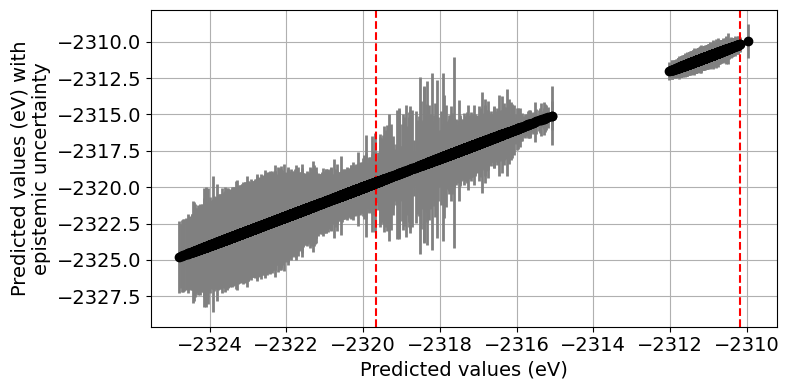

In [57]:
plt.figure(figsize=(8,4))
plt.errorbar(preprocessor_output.inverse_transform(pred_ty_mean).flatten(),
             preprocessor_output.inverse_transform(pred_ty_mean).flatten(), 
             epistemic_error.flatten(),
             fmt='o', color='black',
             ecolor='gray', elinewidth=2, capsize=0)
plt.axvline(x=min_train, color='r', linestyle='--')
plt.axvline(x=max_train, color='r', linestyle='--')
plt.xlabel("Predicted values (eV)", fontsize=14)
plt.ylabel(r"Predicted values (eV) with" 
           "\n" r"epistemic uncertainty",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
#plt.axline([0, 0], [1, 1])
plt.savefig('test-epi-uq.png')

In [58]:
if 0:
    plt.hist(aleatoric_error,bins=np.arange(0.0,5.0,0.1))
    plt.xlabel("Aleatoric uncertainty", fontsize=14)
    plt.ylabel("Frequency",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.tight_layout()

In [59]:
if 0:
    plt.hist(epistemic_error,bins=np.arange(0.0,5.0,0.1))
    plt.xlabel("Epistemic uncertainty", fontsize=14)
    plt.ylabel("Frequency",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.tight_layout()

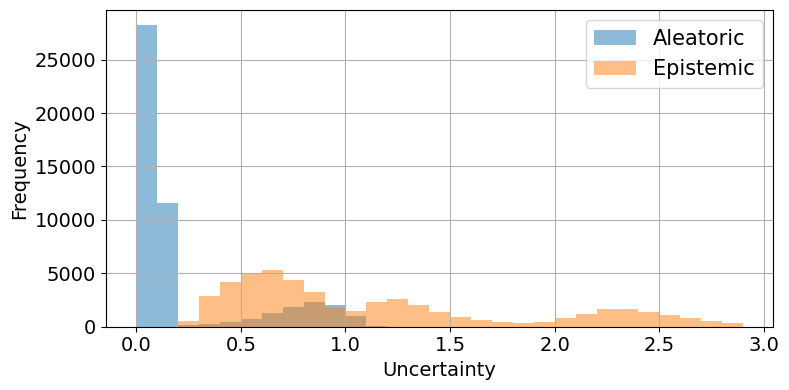

In [60]:
from matplotlib import pyplot

bins = np.arange(0.0,3.0,0.1)

plt.figure(figsize=(8,4))
pyplot.hist(aleatoric_error, bins, alpha=0.5, label='Aleatoric')
pyplot.hist(epistemic_error, bins, alpha=0.5, label='Epistemic')
pyplot.legend(loc='upper right',prop={'size': 15})
pyplot.xlabel("Uncertainty", fontsize=14)
pyplot.ylabel("Frequency",fontsize=14)
pyplot.xticks(fontsize=14)
pyplot.yticks(fontsize=14)
pyplot.grid()
pyplot.tight_layout()
#pyplot.show()
pyplot.savefig('test-hist-uq.png')

In [61]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_vx)

pred_ty_mean = pred_s_ty.loc.numpy() 
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var 
pred_ty_epistemic_var = pred_s_ty_epistemic_var 

In [62]:
# 95.44% interval
pred_ty_aleatoric_interval = np.sqrt(pred_ty_aleatoric_var) 
pred_ty_epistemic_interval = np.sqrt(pred_ty_epistemic_var) 
aleatoric_ub = preprocessor_output.inverse_transform(pred_ty_mean+pred_ty_aleatoric_interval)
mid = preprocessor_output.inverse_transform(pred_ty_mean)
aleatoric_error = aleatoric_ub - mid
epistemic_ub = preprocessor_output.inverse_transform(pred_ty_mean+pred_ty_epistemic_interval)
epistemic_error = epistemic_ub - mid

In [63]:
print(aleatoric_error.shape)
print(epistemic_error.shape)
print(preprocessor_output.inverse_transform(s_vy).flatten().shape)
print(preprocessor_output.inverse_transform(pred_ty_mean).flatten().shape)

(63, 1)
(63, 1)
(63,)
(63,)


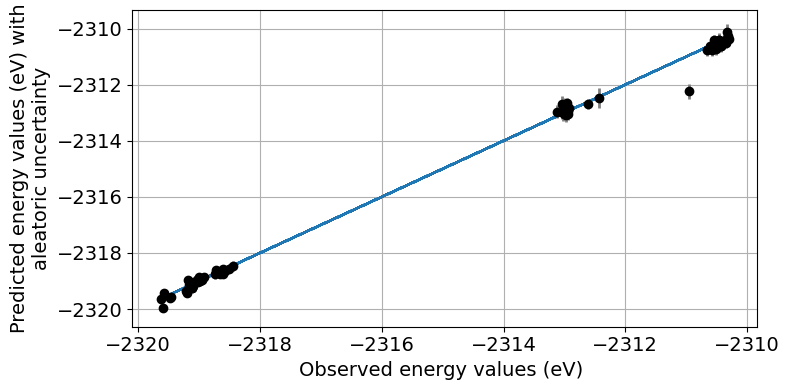

In [64]:
plt.figure(figsize=(8,4))
plt.errorbar(preprocessor_output.inverse_transform(s_vy).flatten(),
             preprocessor_output.inverse_transform(pred_ty_mean).flatten(),
             aleatoric_error.flatten(),
             fmt='o', color='black',
             ecolor='gray', elinewidth=2, capsize=0)
plt.plot(preprocessor_output.inverse_transform(s_vy).flatten(),preprocessor_output.inverse_transform(s_vy).flatten())
plt.xlabel("Observed energy values (eV) ", fontsize=14)
plt.ylabel(r"Predicted energy values (eV) with" 
           "\n" r"aleatoric uncertainty",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
#plt.axline([0, 0], [1, 1])
plt.savefig('val-ale-uq.png')

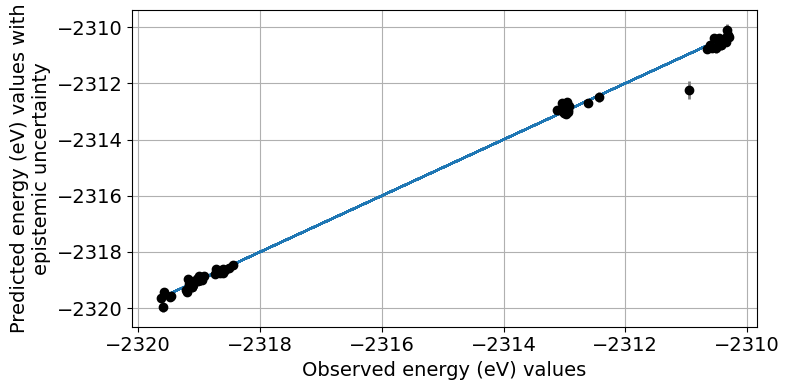

In [65]:
plt.figure(figsize=(8,4))
plt.errorbar(preprocessor_output.inverse_transform(s_vy).flatten(),
             preprocessor_output.inverse_transform(pred_ty_mean).flatten(), 
             epistemic_error.flatten(),
             fmt='o', color='black',
             ecolor='gray', elinewidth=2, capsize=0)
             #linestyle='None', marker='^')
plt.plot(preprocessor_output.inverse_transform(s_vy).flatten(),preprocessor_output.inverse_transform(s_vy).flatten())
plt.xlabel("Observed energy (eV) values", fontsize=14)
plt.ylabel(r"Predicted energy (eV) values with" 
           "\n" r"epistemic uncertainty",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
#plt.axline([0, 0], [1, 1])
plt.savefig('val-epi-uq.png')

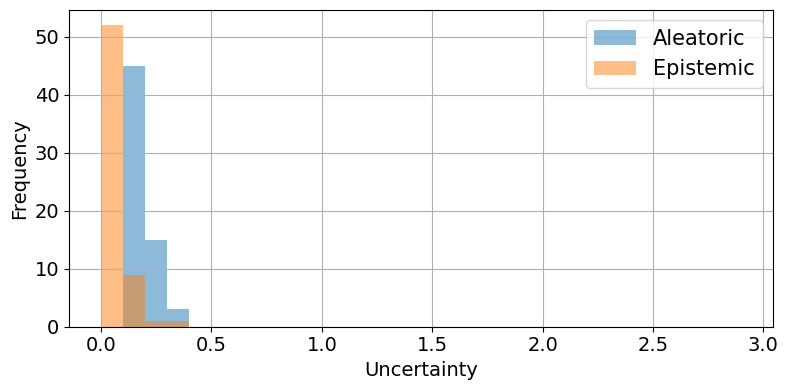

In [66]:
from matplotlib import pyplot

bins = np.arange(0.0,3.0,0.1)

plt.figure(figsize=(8,4))
pyplot.hist(aleatoric_error, bins, alpha=0.5, label='Aleatoric')
pyplot.hist(epistemic_error, bins, alpha=0.5, label='Epistemic')
pyplot.legend(loc='upper right',prop={'size': 15})
pyplot.xlabel("Uncertainty", fontsize=14)
pyplot.ylabel("Frequency",fontsize=14)
pyplot.xticks(fontsize=14)
pyplot.yticks(fontsize=14)
pyplot.grid()
pyplot.tight_layout()
pyplot.savefig('val-hist-uq.png')